# ISM4543 Final Project

### Business Context 
The problem that we are trying to solve is making digital coupon marketing more effective for 
drivers. A lot of coupons sent through a car or a mobile app go unclaimed by the customer; that 
money then gets wasted on people who do not redeem it. Duber is a local food delivery and ride 
hailing company. They need to know whether a driver will accept a coupon. This is based 
explicitly on their situation as well as some things like time of day, weather conditions, who is in 
the car, their destination, etc. Knowing these factors can allow the marketing department to 
send targeted offers to the driver rather than sending them all around and improving overall 
coupon response and ROI. 
From a cost side: 

- **False Negative (FN):** predicting that a driver will not accept when they actually would miss 
conversion **Around $20 in lost revenue per case**.

- **False Positive (FP):** predicting that a driver will accept when they will not **wasted voucher cost ($10/voucher) and reduced campaign efficiency**.

  
Since missing a real acceptance costs more than sending a few extra coupons, we need a high recall to predict correctly, but maintaining a balanced F1 Score is also important in order to avoid wasting too much money => We will focus on Recall and F-1 Score.


### Dataset Provenance 
We are using the **In-Vehicle Coupon Recommendation Dataset** from the **UCI Machine 
Learning Repository**. It was summited in **2019** by researchers at the **University of 
California, Irvine**. The data came from a **survey** where people were shown different driving 
scenarios and asked if they would accept a coupon. There are around **12,684 rows** and **26 
columns** that describe things like age, gender, income, weather, time, and coupon type.   
Because it is survey data and not real world transactions, we are treating it as a way to study 
**driver behavior patterns** rather than trying to predict exact real life outcomes.

# 1. Data Cleaning

## In this section, we clean and prepare the "In-vehicle Coupon Recommendation" dataset for machine learning. The goals are to handle missing values and ensure all the data is ready for analysis.

In [3]:
%pip install ucimlrepo

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,ConfusionMatrixDisplay)
from sklearn.base import clone

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

import warnings
import time
warnings.filterwarnings('ignore')
from ucimlrepo import fetch_ucirepo

Note: you may need to restart the kernel to use updated packages.


In [4]:
dataset = fetch_ucirepo(id=603)
X = dataset.data.features
y = dataset.data.targets

df = pd.concat([X, y], axis=1)
df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [5]:
# Inspect the dataset structure
df.info()
df.describe(include='all').T

print("\nMissing Values per Column:\n")
print((df.isnull().mean()*100).sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passenger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [6]:
# Handle the missing values
#Drop the car column
df=df.drop('car', axis=1)
#Fill null values
df = df.fillna(df.mode().iloc[0])
print("Total missing values after cleaning:", df.isnull().sum().sum())

# Standardize string data
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()
df.head()

Total missing values after cleaning: 0


,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,no urgent place,alone,sunny,55,2pm,restaurant(<20),1d,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,1
1,no urgent place,friend(s),sunny,80,10am,coffee house,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,0
2,no urgent place,friend(s),sunny,80,10am,carry out & take away,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,1
3,no urgent place,friend(s),sunny,80,2pm,coffee house,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0
4,no urgent place,friend(s),sunny,80,2pm,coffee house,1d,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0


In [7]:
# Convert numeric column
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            continue
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passenger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12684 non-null  object
 15  CoffeeHouse           12684 non-null

### Data Cleaning and Preprocessing Summary

### After completing the cleaning, the dataset is now fully prepared for analysis and model development. The data was loaded directly from the UCI Machine Learning Repository using the ucimlrepo library to ensure consistent access across all environments. In the first inspection, we found several columns with missing values, which were replaced with the label "unknown" to preserve all observations. Text-based columns were standardized by converting to lowercase and removing extra spaces, while numeric columns stored as text were properly converted to numeric data types. The "car" column contained about 99% missing values and may be excluded later. The target variable Y is binary (0 = rejected, 1 = accepted), and all columns are now numeric and free of null.

# 2. Exploratory Data Analysis

## Acceptance rate by Weather

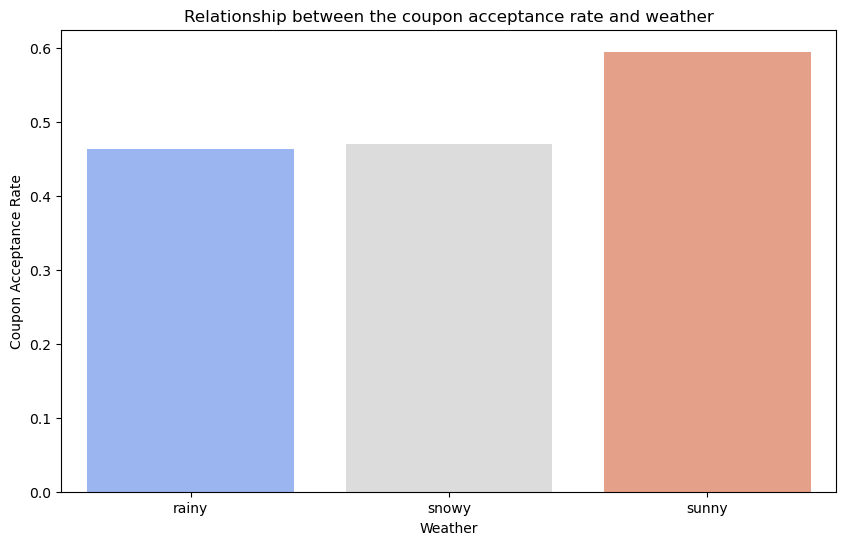

In [8]:
weather_acceptance = df.groupby("weather")["Y"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x="weather", y="Y", data=weather_acceptance, palette="coolwarm")
plt.xlabel("Weather")
plt.ylabel("Coupon Acceptance Rate")
plt.title("Relationship between the coupon acceptance rate and weather")
plt.show()

### Drivers are likely to accept the coupons most when the weather is sunny, while when it's rainy or snowy, the acceptance rate is lower.

## Acceptance Rate by Time of Day

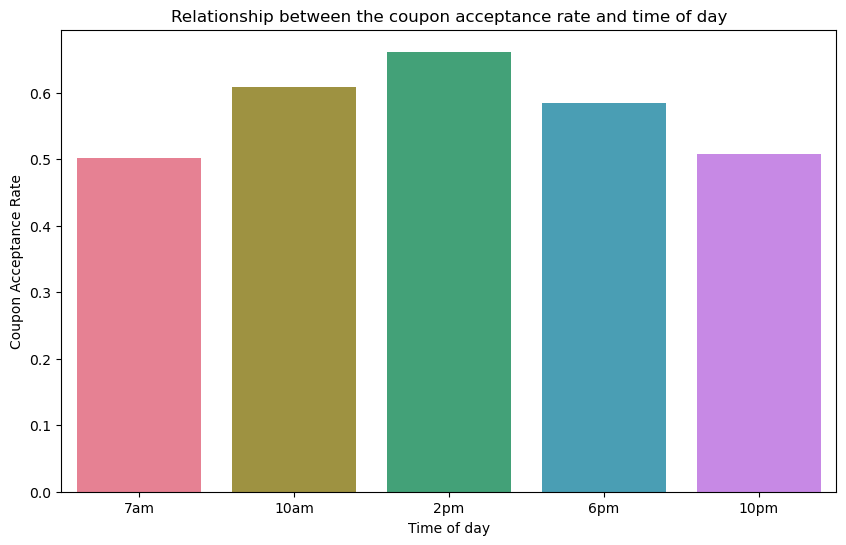

In [9]:
time_order = ['7am', '10am', '2pm', '6pm', '10pm']
time_acceptance = df.groupby("time")["Y"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x="time", y="Y", data=time_acceptance, palette="husl", order = time_order)
plt.xlabel("Time of day")
plt.ylabel("Coupon Acceptance Rate")
plt.title("Relationship between the coupon acceptance rate and time of day")
plt.show()

The coupon acceptance rate varies throughout the day, peaking around 2 PM, when people are most likely to accept coupons. In contrast, the acceptance rate drops significantly by 10 PM, indicating that people are less responsive to coupons later at night.

## Acceptance Rate by Coupon Type

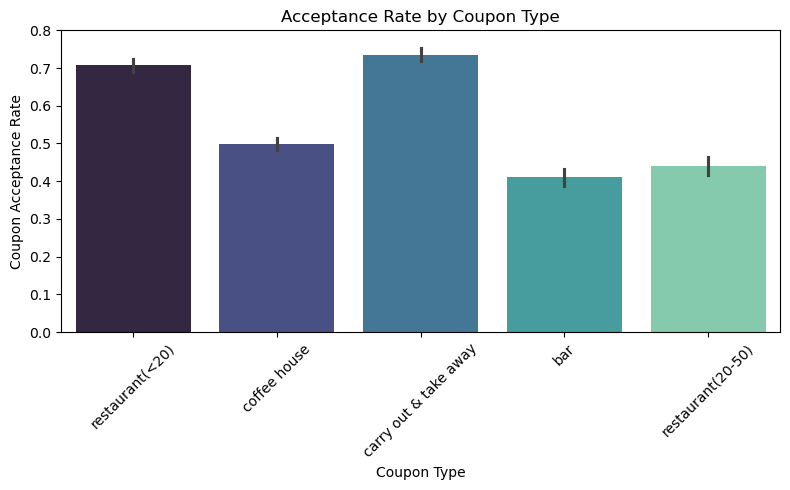

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x='coupon', y='Y', data=df, estimator='mean', palette='mako')
plt.title('Acceptance Rate by Coupon Type')
plt.ylabel('Coupon Acceptance Rate')
plt.ylim(0,0.8)
plt.xlabel('Coupon Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [11]:
print(df['income'].unique())

['$37500 - $49999' '$62500 - $74999' '$12500 - $24999' '$75000 - $87499'
 '$50000 - $62499' '$25000 - $37499' '$100000 or more' '$87500 - $99999'
 'less than $12500']


### Carry out & Take away coupon type is most likely accepted, with an approximately 75% acceptance rate, followed by the Restaurant (<$20) one. Conversely, the Bar coupon type has the lowest acceptance rate, which is nearly 45%.

## Acceptance Rate by Income Level

In [12]:
df['income'].unique()

array(['$37500 - $49999', '$62500 - $74999', '$12500 - $24999',
       '$75000 - $87499', '$50000 - $62499', '$25000 - $37499',
       '$100000 or more', '$87500 - $99999', 'less than $12500'],
      dtype=object)

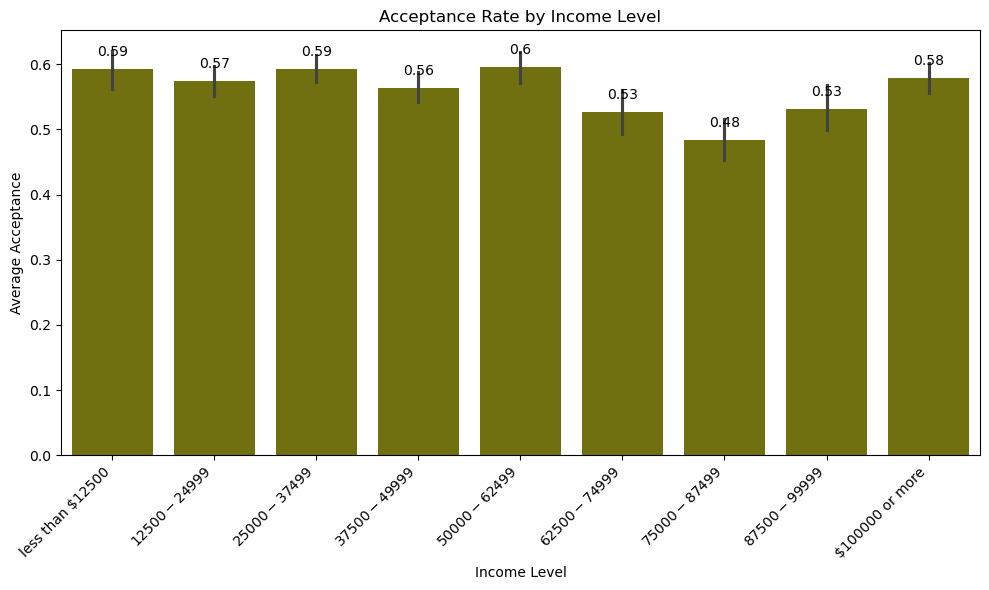

In [13]:
income_order = ['less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499',
          '$87500 - $99999','$100000 or more']

plt.figure(figsize=(10,6))
sns.barplot(x='income', y='Y', data=df, color='olive',order=income_order)
plt.title('Acceptance Rate by Income Level')
plt.ylabel('Average Acceptance')
plt.xlabel('Income Level')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for i in range(len(income_order)):
    val = df.loc[df['income'] == income_order[i], 'Y'].mean()
    plt.text(i, val + 0.02, str(round(val, 2)), ha='center' )
plt.show()



### The average acceptance rate is highest among \$50000 - \$62499 income group, while middle-income users (around $75000–$87499) are the least likely to accept coupons.

## Coupon Acceptance Rate by Distance to Coupon

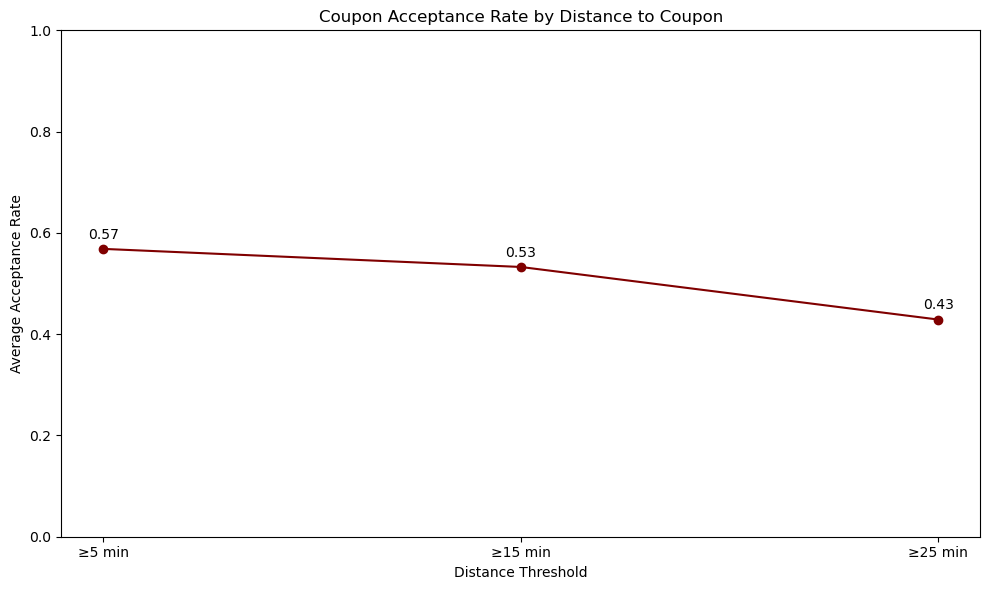

In [14]:
distance = [
    df.loc[df['toCoupon_GEQ5min'] == 1, 'Y'].mean(),
    df.loc[df['toCoupon_GEQ15min'] == 1, 'Y'].mean(),
    df.loc[df['toCoupon_GEQ25min'] == 1, 'Y'].mean()
]

plt.figure(figsize=(10,6))
plt.plot(['≥5 min', '≥15 min', '≥25 min'], distance, marker='o', color='maroon')
plt.title('Coupon Acceptance Rate by Distance to Coupon')
plt.ylabel('Average Acceptance Rate')
plt.ylim(0,1)
plt.xlabel('Distance Threshold')
plt.tight_layout()
for i in range(len(distance)):
    val = distance[i]
    plt.text(i, val + 0.02, str(round(val, 2)), ha='center' )
plt.show()






The shorter the distance to the coupon places is, the higher the acceptance rate is. As the needed driving distance rises from 5 to 25 minutes, the acceptance rate consistently falls, indicating that people are less willing to use coupons that require longer travel.

## Overall Coupon Acceptance Rate

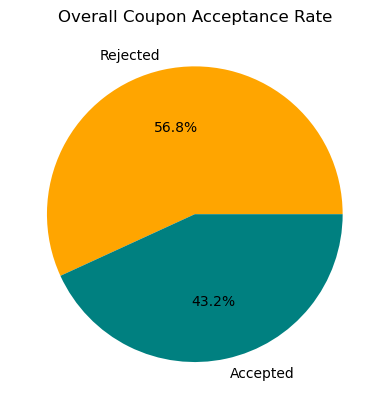

In [15]:
acceptance_counts = df['Y'].value_counts()
plt.pie(acceptance_counts, labels=['Rejected', 'Accepted'], autopct='%1.1f%%', colors=['orange','teal'])
plt.title('Overall Coupon Acceptance Rate')
plt.show()

In the dataset, 56.8% of the observations are rejected, while 43,2% of them are accepted. This imbalance is not too severe, so there's no need for synthetic balancing techniques

# 3. Data Pre-processing and Feature Engineering

In [16]:
df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,no urgent place,alone,sunny,55,2pm,restaurant(<20),1d,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,1
1,no urgent place,friend(s),sunny,80,10am,coffee house,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,0,0,0,1,0
2,no urgent place,friend(s),sunny,80,10am,carry out & take away,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,1
3,no urgent place,friend(s),sunny,80,2pm,coffee house,2h,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0
4,no urgent place,friend(s),sunny,80,2pm,coffee house,1d,female,21,unmarried partner,...,never,1~3,4~8,1~3,1,1,0,0,1,0


## Drop the direction_same column

In [17]:
df.drop(['direction_same'], axis=1, inplace=True)

## Create a new column called distToCoupon

In [18]:
# Define the conditions (based on the presence of 1s)
conditions = [
    # Case 1: Time >= 25 mins
    (df['toCoupon_GEQ25min'] == 1),

    # Case 2: Time >= 15 mins AND < 25 mins
    (df['toCoupon_GEQ15min'] == 1) & (df['toCoupon_GEQ25min'] == 0),

    # Case 3: Time >= 5 mins AND < 15 mins
    # Since we established that the GEQ5min column is always 1, we just need GEQ15min to be 0
    (df['toCoupon_GEQ5min'] == 1) & (df['toCoupon_GEQ15min'] == 0)
]

# Define the values for the new column corresponding to the conditions
choices = [
    '25+ min',
    '15-25 min',
    '5-15 min'
]

# Create the new column 'distToCoupon'
# The 'default' value handles any scenarios that don't fit (e.g., if a 0,0,0 row existed)
df['distToCoupon'] = np.select(conditions, choices, default='< 5 min')

In [19]:
# Drop the original redundant binary columns
df = df.drop(columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'])

# Verification of the new feature:
print("New Feature Head")
print(df[['distToCoupon']].head())
print("\n New Feature Value Counts")
print(df['distToCoupon'].value_counts())

New Feature Head
  distToCoupon
0     5-15 min
1     5-15 min
2    15-25 min
3    15-25 min
4    15-25 min

 New Feature Value Counts
distToCoupon
15-25 min    5611
5-15 min     5562
25+ min      1511
Name: count, dtype: int64


## Encode Ordinal Categorical Variables

In [20]:
# Define the standard mapping from least frequent (0) to most frequent (4) for 'Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50'
# The key is the text value found in the dataset, and the value is the numerical rank.
df_encoded = df.copy()

frequency_mapping = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4,

    # Handle the specific error in the Bar column and generic NaNs:
    'nan4~8': 3,  # Treating this as a typo and mapping to the 4~8 frequency
    np.nan: 0     # Imputing any generic NaN as 'never' (0) - adjust if 'Unknown' is better
}

# List of all preference columns
preference_cols = [
    'Bar', 'CoffeeHouse', 'CarryAway',
    'RestaurantLessThan20', 'Restaurant20To50'
]

# Apply the mapping across all columns
for col in preference_cols:
    # Fill any generic pandas NaNs first (if not already done by the mapping)
    df_encoded[col] = df_encoded[col].fillna('never')

    # Apply the ordinal mapping
    df_encoded[col] = df_encoded[col].map(frequency_mapping)


print(df_encoded[['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']].head(10))

   Bar  CoffeeHouse  CarryAway  RestaurantLessThan20  Restaurant20To50
0    0            0          2                     3                 2
1    0            0          2                     3                 2
2    0            0          2                     3                 2
3    0            0          2                     3                 2
4    0            0          2                     3                 2
5    0            0          2                     3                 2
6    0            0          2                     3                 2
7    0            0          2                     3                 2
8    0            0          2                     3                 2
9    0            0          2                     3                 2


In [21]:
# # Determining variable types
# numeric_col=['temperature']
# binary_col=['gender','has_children']
# categorical_col=['distToCoupon', 'destination', 'passenger', 'weather', 'time', 'coupon', 'expiration', 'maritalStatus','occupation', 'income']
# ordinal_col=['education','age','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']
# target = ['Y']

## Initialize Cleaning Data Pre-processing Pipeline

Mapping the data

In [22]:

# 1. Define Columns Based on Type

# Nominal Features
nominal_col = [
    'distToCoupon',
    'destination',
    'passenger',
    'weather',
    'time',
    'coupon',
    'expiration',
    'maritalStatus',
    'occupation',
    'income',
    'gender'
]

# Ordinal Features
ordinal_col = [
    'education',
    'income',
    'age'
]

# Frequency Features
frequency_col = [
    'Bar', 'CoffeeHouse', 'CarryAway',
    'RestaurantLessThan20', 'Restaurant20To50'
]
# Numeric Features
numeric_col = ['temperature']



In [23]:
# 2. Define Ordinal Category Orders

# Standard Binary and Ordinal Order (Education, Income)


education_order = ['some high school',
                   'high school graduate',
                   'some college - no degree',
                   'associates degree',
                   'bachelors degree',
                   'graduate degree (masters or doctorate)']

income_order = ['less than $12500', '$12500 - $24999',
                '$25000 - $37499', '$37500 - $49999',
                '$50000 - $62499', '$62500 - $74999',
                '$75000 - $87499', '$87500 - $99999', '$100000 or more']

age_order = ['below21', '21', '26', '31', '36', '41', '46', '50plus']

# Frequency Order (from 'never' to 'gt8')
frequency_order = ['never', 'less1', '1~3', '4~8', 'gt8']

# Combine all ordinal category orders into one list
all_ordinal_categories = [
    education_order,
    income_order,
    age_order,
    frequency_order,
    frequency_order,
    frequency_order,
    frequency_order,
    frequency_order
]


## Build a preprocessing pipeline

In [24]:
# 3. Build Preprocessing Steps

# Pipeline for Nominal Features (One-Hot Encoding)
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop = 'first'))
])

# Pipeline for Ordinal Features
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=all_ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

# Pipeline for Numerical Features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


In [25]:
# 4. Combine Pipelines using ColumnTransformer
# Note: The order of columns in 'all_ordinal_categories' must match the combined list of ORDINAL_COLS and FREQUENCY_COLS
preprocessing_transformer = ColumnTransformer(
    transformers=[
        ('nominal_enc', nominal_pipeline, nominal_col),
        ('ordinal_enc', ordinal_pipeline, ordinal_col + frequency_col),
        ('numeric_pass', numerical_pipeline, numeric_col)
    ],
    # 'remainder='passthrough' ensures any columns not listed above stays
    remainder='passthrough'
)


In [26]:
# 5. Final Full Pipeline

cleaning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_transformer)
])

## Split the data

In [27]:
# Train Test Split
X = df.drop(['Y'], axis=1)
y = df['Y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (12684, 21)
Target shape: (12684,)
Target distribution:
Y
1    7210
0    5474
Name: count, dtype: int64


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      # 70/30 split
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 8878
Test set size: 3806


## Fit and transform the data

In [29]:
# 1. Fit and Transform the Training Data

X_train_processed = cleaning_pipeline.fit_transform(X_train)

# 2. Transform the Test Data
X_test_processed = cleaning_pipeline.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

X_train_processed shape: (8878, 66)
X_test_processed shape: (3806, 66)


In [30]:
pd.DataFrame(X_train_processed, columns=preprocessing_transformer.get_feature_names_out()).head()

,nominal_enc__distToCoupon_25+ min,nominal_enc__distToCoupon_5-15 min,nominal_enc__destination_no urgent place,nominal_enc__destination_work,nominal_enc__passenger_friend(s),nominal_enc__passenger_kid(s),nominal_enc__passenger_partner,nominal_enc__weather_snowy,nominal_enc__weather_sunny,nominal_enc__time_10pm,...,ordinal_enc__income,ordinal_enc__age,ordinal_enc__Bar,ordinal_enc__CoffeeHouse,ordinal_enc__CarryAway,ordinal_enc__RestaurantLessThan20,ordinal_enc__Restaurant20To50,numeric_pass__temperature,remainder__has_children,remainder__direction_opp
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,3.0,3.0,2.0,1.0,2.0,0.5,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,5.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,8.0,3.0,0.0,3.0,4.0,3.0,1.0,1.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,8.0,0.0,0.0,2.0,3.0,3.0,2.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,2.0,1.0,3.0,1.0,4.0,2.0,2.0,0.5,0.0,1.0


# 4.Model selection and justification

As our current dataset consists mostly of categorical data, and this is a supervised binary classification problem, we would prefer models that can handle mixed feature types, non-linear relationships, and moderate dimensions.

Below are baseline models that we would use:

- **Logistic Regression**: A simple and interpretable linear baseline to evaluate how well basic relationships could explain coupon acceptance.  
- **Decision Tree Classifier**: The model provides transparent, rule-based decisions that enable an easy explanation of how feature thresholds influence results.  
- **Random Forest**: An ensemble of decision trees that captures more complex, non-linear interactions.

After training and evaluating these baseline models, we will select the best-performing one as our primary model and perform hyperparameter tuning.  

Metrics that we will focus most on are **Recall** and **F1 Score**. Duber loses **\$20 in revenue for each false negative**, while **false positives cause a \$10 loss per case**. As the cost of a FN is higher than that of a FP, we need a high Recall that helps maximize potential revenue by identifying more customers who will accept the voucher. At the same time, it's also necessary to have a strong **F1 Score** that balances recall and precision, which ensures marketing resources are used efficiently.



# 5. Model Training and Evaluation

In [31]:
def evaluate_and_visualize_models(models_dict, X_train, y_train, X_test, y_test):
    """
    Trains models, evaluates both train and test performance, 
    shows confusion matrices, and visualizes performance comparison.

    Args:
        models_dict (dict): {model_name: model_object}
        X_train, y_train: Training data
        X_test, y_test: Test data

    Returns:
        pd.DataFrame: Comparison of Train vs Test metrics for each model
    """
    results = {}
    trained_models = {}
    train_times={}

    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    class_labels = np.unique(y_test)
    minority_class_label = str(class_labels[-1])

    for name, model in models_dict.items():
        model_clone = clone(model)
        print(f"\n--- Training and Evaluating: {name} ---")

        # Train
        start_time = time.time()
        try:
            model_clone.fit(X_train, y_train)
        except Exception as e:
            print(f"Error fitting {name}: {e}. Skipping this model.")
            continue
        end_time = time.time()
        train_time = end_time - start_time
        train_times[name] = round(train_time, 2)
        trained_models[name] = model_clone

        # Predictions
        y_train_pred = model_clone.predict(X_train)
        y_test_pred = model_clone.predict(X_test)

        # Classification reports
        report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
        report_test  = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

        print("Train Classification Report:")
        print(classification_report(y_train, y_train_pred))
        print("Test Classification Report:")
        print(classification_report(y_test, y_test_pred))

        # Store both train and test metrics
        results[name] = {
            'Train Accuracy': report_train['accuracy'],
            'Train Recall': report_train[minority_class_label]['recall'],
            'Train Precision': report_train[minority_class_label]['precision'],
            'Train F1': report_train[minority_class_label]['f1-score'],
            'Test Accuracy': report_test['accuracy'],
            'Test Recall': report_test[minority_class_label]['recall'],
            'Test Precision': report_test[minority_class_label]['precision'],
            'Test F1': report_test[minority_class_label]['f1-score'],
    
        }

        # 3: Confusion Matrix for Test Set
        print('Training Time (s): ',round(train_time, 2))
        fig, ax = plt.subplots(figsize=(4, 4))
        ConfusionMatrixDisplay.from_estimator(
            model_clone, X_test, y_test, cmap=plt.cm.Blues,
            ax=ax, display_labels=class_labels
        )
        ax.set_title(f'Confusion Matrix: {name}')
        plt.show()

    # 4️: Create train vs test comparison table
    comparison_df = pd.DataFrame(results).T
    organized_table = pd.DataFrame({
        'Train': [
            comparison_df['Train Accuracy'].iloc[0],
            comparison_df['Train Recall'].iloc[0],
            comparison_df['Train Precision'].iloc[0],
            comparison_df['Train F1'].iloc[0]
        ],
        'Test': [
            comparison_df['Test Accuracy'].iloc[0],
            comparison_df['Test Recall'].iloc[0],
            comparison_df['Test Precision'].iloc[0],
            comparison_df['Test F1'].iloc[0]
        ]
    }, index=['Accuracy', 'Recall', 'Precision', 'F1'])

    # Display the organized table
    print("\n--- Train vs Test Comparison Table ---")
    display(organized_table.round(4))


    # 5️: Visualization: Bar chart comparing Train vs Test performance
      
    plt.figure(figsize=(8,5))
 
    melted = comparison_df.reset_index().melt(id_vars='index', var_name='Set_Metric', value_name='Score')
    melted[['Set', 'Metric']] = melted['Set_Metric'].str.split(' ', expand=True)

    for model_name in comparison_df.index:
        df_model = melted[melted['index'] == model_name].pivot(index='Metric', columns='Set', values='Score')
        df_model.plot(kind='bar', figsize=(8,5))
        plt.title(f'{model_name}: Train vs Test Performance')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()

    return comparison_df, trained_models, train_times

## Logistic Regression Base


--- Training and Evaluating: LR Baseline ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      3831
           1       0.70      0.77      0.73      5047

    accuracy                           0.68      8878
   macro avg       0.68      0.67      0.67      8878
weighted avg       0.68      0.68      0.68      8878

Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      1643
           1       0.69      0.78      0.73      2163

    accuracy                           0.68      3806
   macro avg       0.67      0.66      0.66      3806
weighted avg       0.67      0.68      0.67      3806

Training Time (s):  0.17


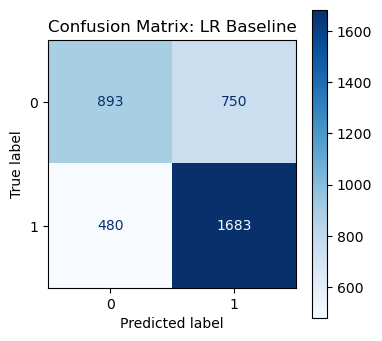


--- Train vs Test Comparison Table ---


,Train,Test
Accuracy,0.6825,0.6768
Recall,0.7708,0.7781
Precision,0.7006,0.6917
F1,0.7340,0.7324


<Figure size 800x500 with 0 Axes>

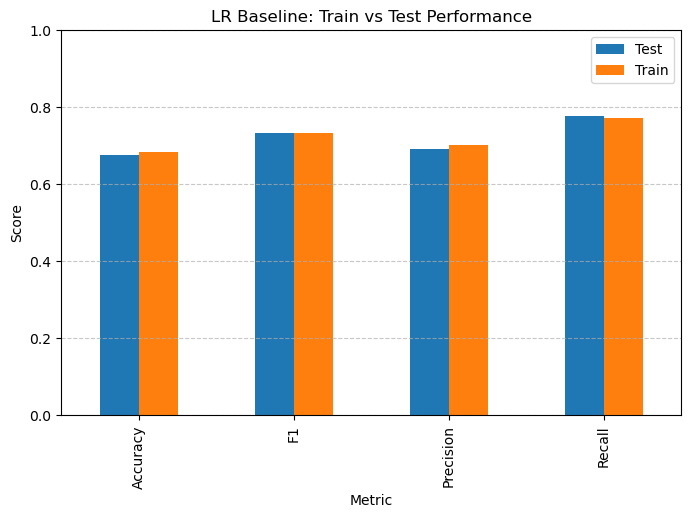

In [32]:
lr_dict = {
    "LR Baseline" : LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.1, random_state = 42)
}

lr_base_comparison_result,trained_lr,train_times_lr = evaluate_and_visualize_models(
    lr_dict,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test
)

## Decision Tree Classifier Base


--- Training and Evaluating: DT Baseline ---
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3831
           1       1.00      1.00      1.00      5047

    accuracy                           1.00      8878
   macro avg       1.00      1.00      1.00      8878
weighted avg       1.00      1.00      1.00      8878

Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1643
           1       0.72      0.72      0.72      2163

    accuracy                           0.68      3806
   macro avg       0.67      0.67      0.67      3806
weighted avg       0.68      0.68      0.68      3806

Training Time (s):  0.13


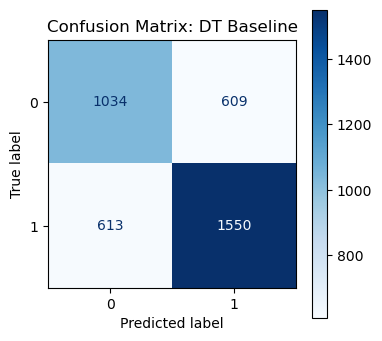


--- Train vs Test Comparison Table ---


,Train,Test
Accuracy,0.9988,0.6789
Recall,0.9978,0.7166
Precision,1.0000,0.7179
F1,0.9989,0.7173


<Figure size 800x500 with 0 Axes>

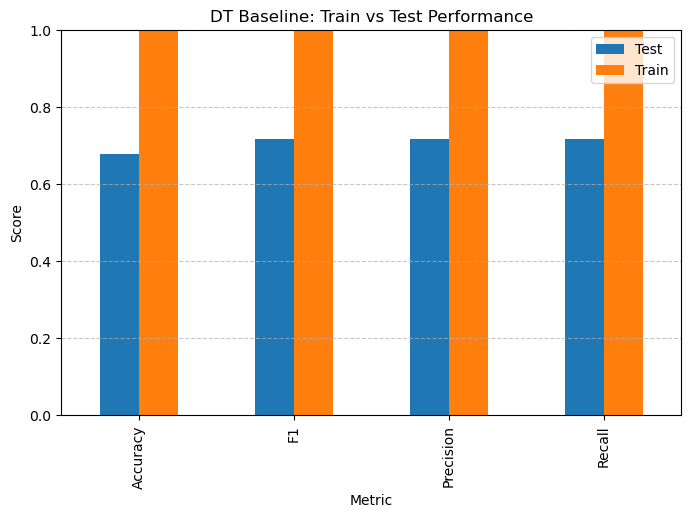

In [33]:
dt_dict = {
    "DT Baseline": DecisionTreeClassifier(random_state=42)
}

dt_comparison_result,trained_dt,train_times_dt = evaluate_and_visualize_models(
    dt_dict,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test
)


## Random Forest Base


--- Training and Evaluating: RF Baseline ---
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3831
           1       1.00      1.00      1.00      5047

    accuracy                           1.00      8878
   macro avg       1.00      1.00      1.00      8878
weighted avg       1.00      1.00      1.00      8878

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1643
           1       0.74      0.82      0.78      2163

    accuracy                           0.74      3806
   macro avg       0.73      0.72      0.73      3806
weighted avg       0.74      0.74      0.73      3806

Training Time (s):  2.03


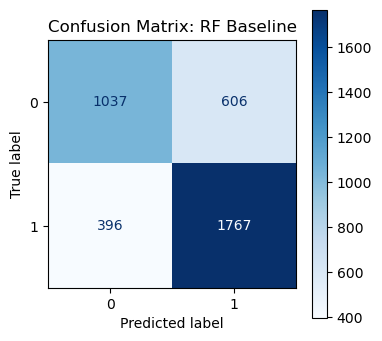


--- Train vs Test Comparison Table ---


,Train,Test
Accuracy,0.9988,0.7367
Recall,0.9994,0.8169
Precision,0.9984,0.7446
F1,0.9989,0.7791


<Figure size 800x500 with 0 Axes>

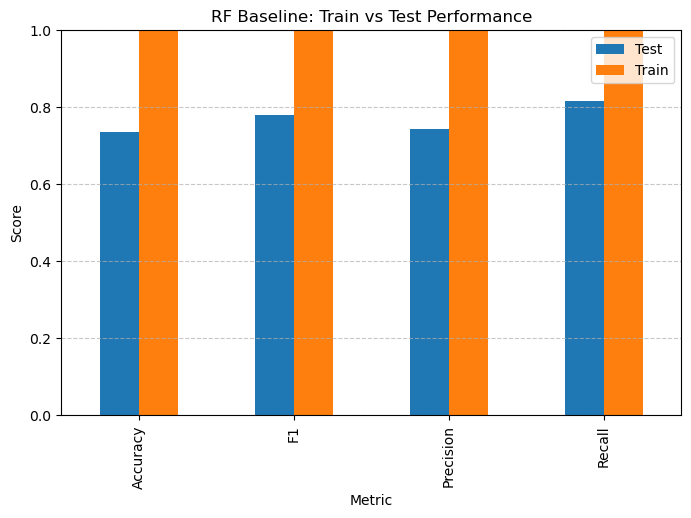

In [34]:
rf=RandomForestClassifier(n_estimators=100, random_state=42)
rf_dict = {
    "RF Baseline": rf
}

rf_comparison_result,trained_rf,train_times_rf = evaluate_and_visualize_models(
    rf_dict,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test
)


# 6. Hyperparameter Tuning and Ensemble Models

In [34]:
score_measure = 'f1'
k_fold = 5

## Random Forest Optimized

In [35]:
rf_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [9, 12, 15],
    'max_features': ['sqrt', 0.7, 0.9], # Allowing more features to be considered
    'min_samples_split': [20, 30, 50],
    'min_samples_leaf': [5, 10, 20], # Allowing more detailed splits
    'max_samples': [0.4, 0.5, 0.6],
    'class_weight': ['balanced'],
    'random_state': [42]
}

rf_gridSearch = GridSearchCV(
    RandomForestClassifier(),
    rf_param_grid,
    cv=k_fold,
    scoring=score_measure,
    n_jobs=-1
)

rf_gridSearch.fit(X_train_processed, y_train)
print(f"{score_measure} score: {rf_gridSearch.best_score_:.4f}")
print(f"Best parameters: {rf_gridSearch.best_params_}")

bestRF = rf_gridSearch.best_estimator_

f1 score: 0.7655
Best parameters: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 0.9, 'max_samples': 0.6, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 300, 'random_state': 42}


In [35]:
rf_best = RandomForestClassifier(
    class_weight='balanced',
    max_depth=15,
    max_features=0.9,
    max_samples=0.6,
    min_samples_leaf=5,
    min_samples_split=20,
    n_estimators=300,
    random_state=42
)



In [36]:
optimized_models = {
    "RF Optimized": rf_best
}



--- Training and Evaluating: RF Optimized ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3831
           1       0.85      0.84      0.84      5047

    accuracy                           0.82      8878
   macro avg       0.82      0.82      0.82      8878
weighted avg       0.82      0.82      0.82      8878

Test Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1643
           1       0.76      0.75      0.76      2163

    accuracy                           0.72      3806
   macro avg       0.72      0.72      0.72      3806
weighted avg       0.72      0.72      0.72      3806

Training Time (s):  10.13


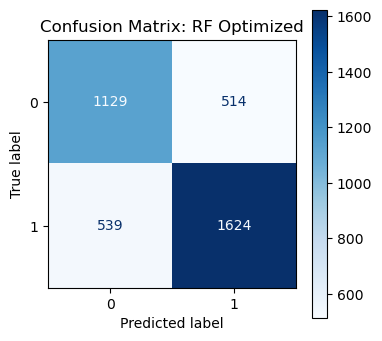


--- Train vs Test Comparison Table ---


,Train,Test
Accuracy,0.8202,0.7233
Recall,0.8359,0.7508
Precision,0.8460,0.7596
F1,0.8409,0.7552


<Figure size 800x500 with 0 Axes>

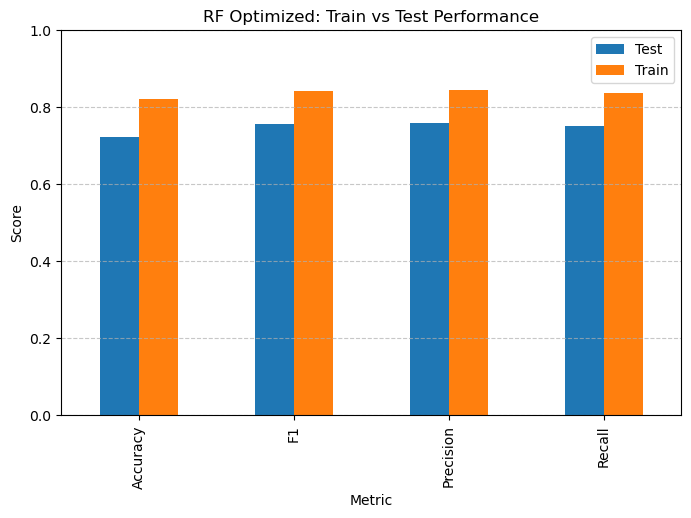

In [37]:
comparison_df_rf_opt, trained_rf_opt, train_times_rf_opt = evaluate_and_visualize_models(
    optimized_models,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test
)


In [38]:
importances = trained_rf_opt['RF Optimized'].feature_importances_
feature_names = preprocessing_transformer.get_feature_names_out()
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

Text(0, 0.5, 'Feature')

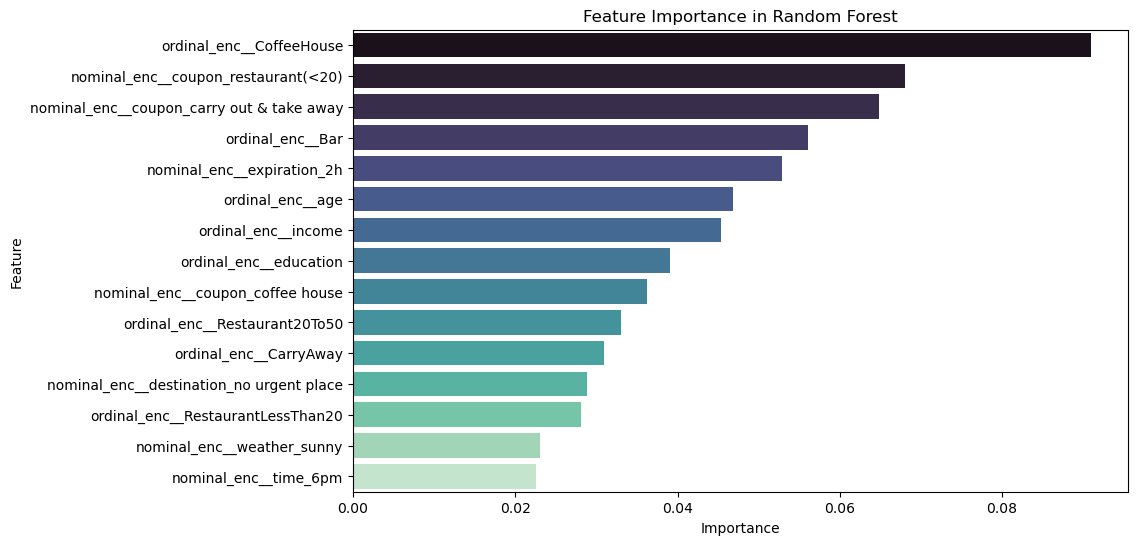

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importances[:15], palette='mako')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

### Top Features

- **ordinal_enc_CoffeeHouse**  
  - **What it means:** Frequency of visits to coffee houses (ordinally encoded).  
  - **Business Insight:** Most influential feature. Drivers who regularly visit coffee houses are much more likely to accept coupons related to food or beverages. Duber should especially target these frequent visitors for maximum coupon acceptance.  

- **nominal_enc_coupon_restaurant(<20)**  
  - **What it means:** Whether the coupon is for a restaurant meal costing under $20.  
  - **Business Insight:** Very important. Coupons for inexpensive dining are highly attractive and the model reliably identifies these offers as key acceptance drivers.  

- **nominal_enc__coupon_carry out & take away**  
  - **What it means:** Whether the coupon is for carryout or take-away food.  
  - **Business Insight:** Also highly important. Targeting customers with carry-out offers aligns with strong acceptance patterns.  

- **ordinal_enc__Bar**  
  - **What it means:** Frequency of visits to bars (ordinally encoded).  
  - **Business Insight:** This signals that people who often visit bars are likely to accept bar-related coupons and possibly food or drink coupons as well.  

- **nominal_enc__expiration_2h**  
  - **What it means:** Coupons expiring in 2 hours.  
  - **Business Insight:** A shorter expiration can create urgency, influencing acceptance rates; model finds this a notable factor.


# 7. Final Model Selection

In [44]:
final_comparison = pd.concat([
    lr_base_comparison_result,
    rf_comparison_result,
    dt_comparison_result,
    comparison_df_rf_opt
])
train_times_all = {**train_times_lr, **train_times_rf, **train_times_dt, **train_times_rf_opt}
final_comparison["Train Time (s)"] = final_comparison.index.map(train_times_all)



In [45]:
results_df = pd.DataFrame(final_comparison)
results_df = results_df.reset_index().rename(columns={'index': 'Model'})
results_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1,Train Time (s)
0,LR Baseline,0.682474,0.770755,0.700648,0.734032,0.676826,0.778086,0.691739,0.732376,0.17
1,RF Baseline,0.998761,0.999406,0.998416,0.998911,0.736731,0.816921,0.744627,0.779101,2.03
2,DT Baseline,0.998761,0.997820,1.000000,0.998909,0.678928,0.716597,0.717925,0.717261,0.13
3,RF Optimized,0.820230,0.835942,0.846000,0.840941,0.723332,0.750809,0.759588,0.755173,10.13


Train vs Test performance for 4 models

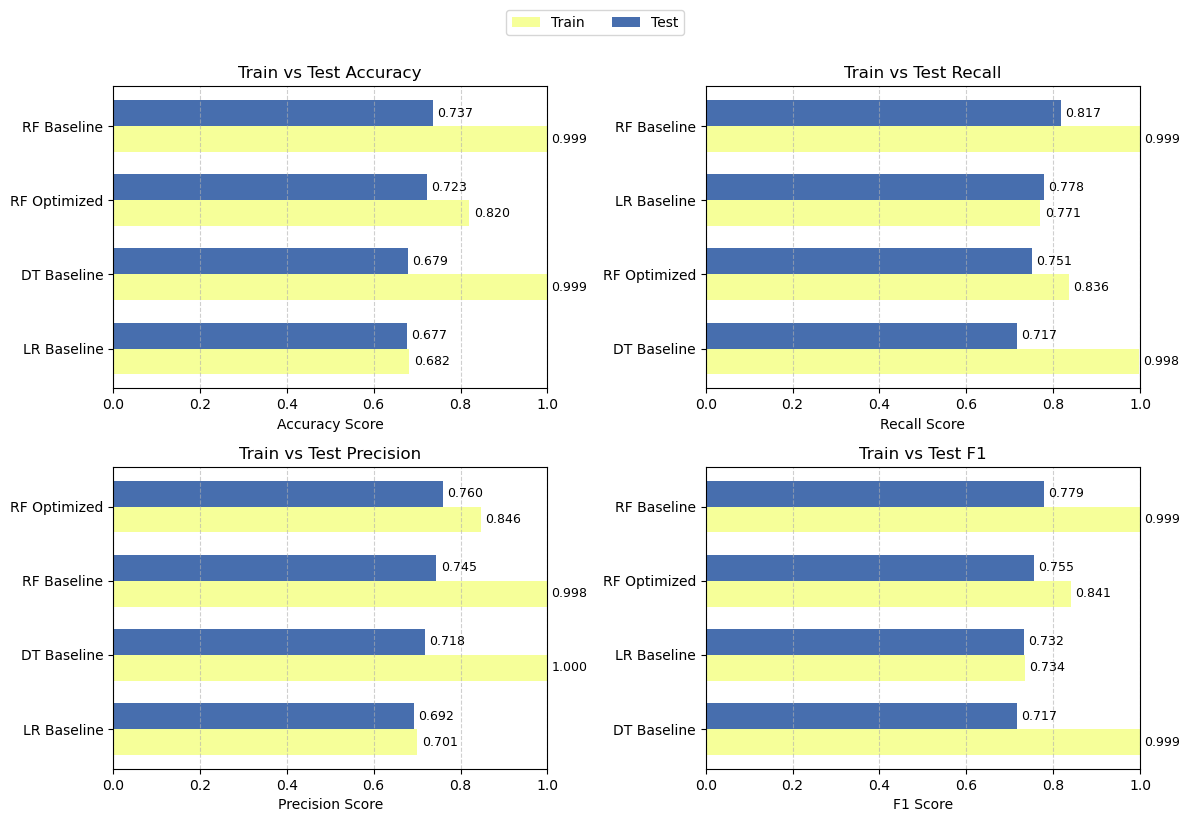

In [46]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Custom colors
train_color = "#F6FF99"  
test_color = "#476EAE"   

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Sort by Test metric (descending)
    sorted_df = results_df.sort_values(by=f'Test {metric}', ascending=True)
    
    y = np.arange(len(sorted_df['Model']))
    height = 0.35
    train_vals = sorted_df[f'Train {metric}'].values
    test_vals = sorted_df[f'Test {metric}'].values

    # Horizontal bars
    ax.barh(y - height/2, train_vals, height, label='Train', color=train_color)
    ax.barh(y + height/2, test_vals, height, label='Test', color=test_color)

    # Add value labels
    for j in range(len(y)):
        ax.text(train_vals[j] + 0.01, y[j] - height/2, f"{train_vals[j]:.3f}", va='center', ha='left', fontsize=9)
        ax.text(test_vals[j] + 0.01, y[j] + height/2, f"{test_vals[j]:.3f}", va='center', ha='left', fontsize=9)

    # Formatting
    ax.set_yticks(y)
    ax.set_yticklabels(sorted_df['Model'])
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric + ' Score')
    ax.set_title(f'Train vs Test {metric}')
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# Add legend 
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Training Time Comparison Chart

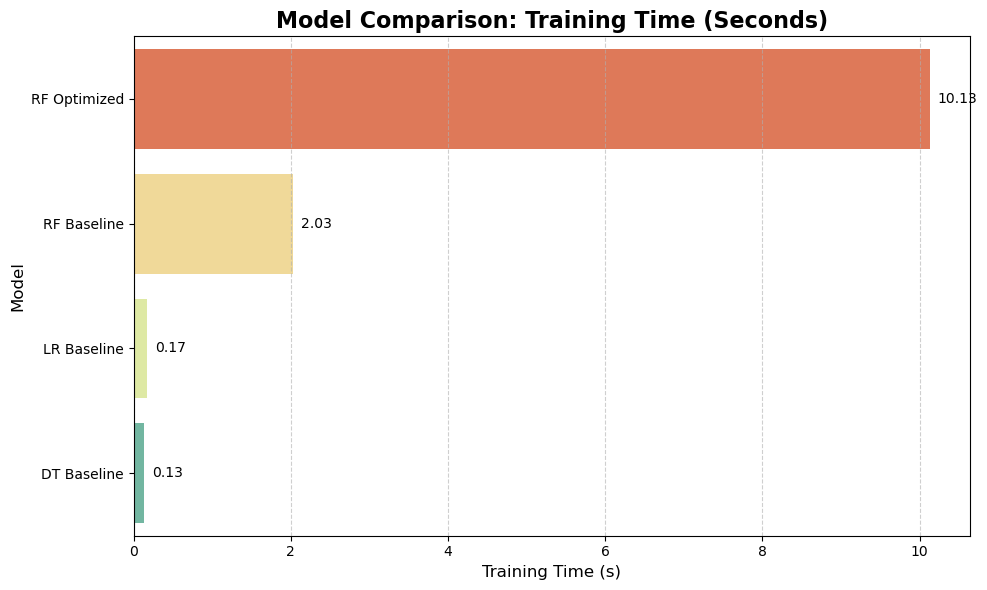

In [48]:
# Sort by training time (descending)
train_time_df = results_df.sort_values(by='Train Time (s)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Train Time (s)',
    y='Model',
    data=train_time_df,
    palette='Spectral'
)

plt.title('Model Comparison: Training Time (Seconds)', fontsize=16, weight='bold')
plt.xlabel('Training Time (s)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add labels on bars
for index, value in enumerate(train_time_df['Train Time (s)']):
    plt.text(value + (0.01 * max(train_time_df['Train Time (s)'])), index, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Decision**

Based on the results of our first three base models and using the F1 score as our evaluation metric, we decided to proceed with the Random Forest model. Logistic Regression achieved a moderate score with no signs of overfitting, while the Decision Tree model severely overfit and produced the lowest test score. Random Forest showed moderate overfitting but achieved the highest test score, making it our choice for hyperparameter tuning. After tuning, the model’s performance slightly decreased, but the overfitting gap was moderately reduced. Though the training time is higher than the others, the computational cost remained manageable and appropriate for our problem’s scale.

## Final Model

In [49]:
final_model=trained_rf_opt['RF Optimized']

In [50]:

final_pred = final_model.predict(X_test_processed)

In [51]:
# 1. Make sure y_test is a Series with same index
y_test_final = pd.Series(y_test, index=X_test.index, name='actual')

# 2. Make sure predictions align with X_test
final_pred_series = pd.Series(final_pred.ravel(), index=X_test.index, name='predicted')

# 3. Combine
final_df = pd.concat([X_test, y_test_final, final_pred_series], axis=1)

In [52]:
final_df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_opp,distToCoupon,actual,predicted
8774,home,alone,snowy,30,10pm,restaurant(20-50),2h,female,50plus,single,...,$87500 - $99999,1~3,1~3,less1,1~3,less1,1,5-15 min,0,0
2713,no urgent place,friend(s),sunny,80,10am,coffee house,2h,male,21,single,...,$87500 - $99999,1~3,1~3,1~3,4~8,1~3,1,5-15 min,1,1
1958,work,alone,sunny,55,7am,bar,1d,male,41,married partner,...,$50000 - $62499,less1,4~8,4~8,1~3,less1,1,25+ min,1,0
1967,no urgent place,friend(s),sunny,80,2pm,coffee house,1d,male,36,married partner,...,$75000 - $87499,1~3,1~3,1~3,4~8,less1,1,15-25 min,0,1
2119,no urgent place,friend(s),sunny,80,10am,bar,1d,female,21,single,...,less than $12500,less1,1~3,4~8,gt8,less1,1,5-15 min,1,1


# 8. Business Recommendation

Coupon Acceptance Rate by Coupon Type: Actual vs Predicted

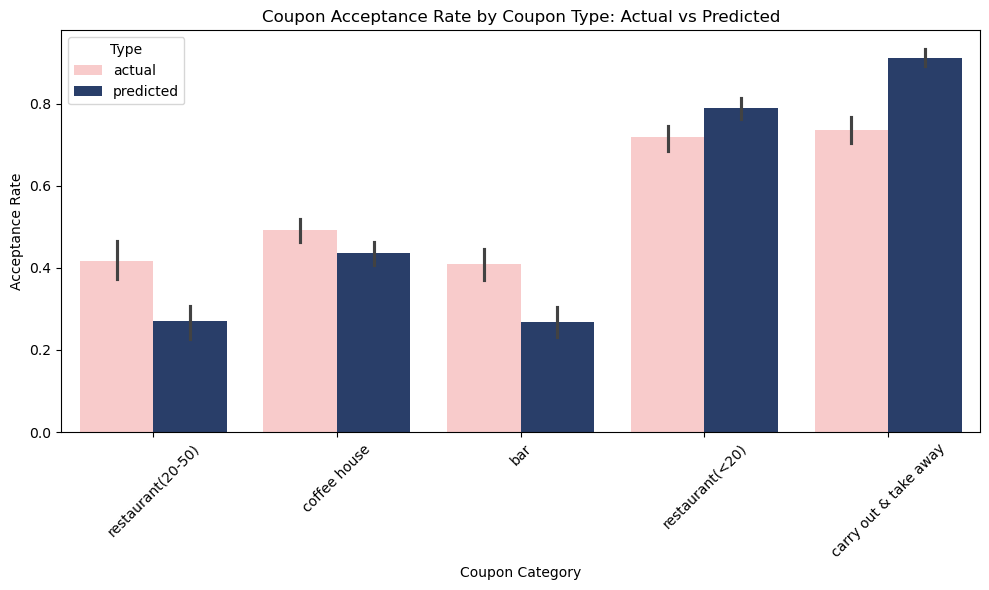

In [53]:
# Melt the dataframe for seaborn
acceptance_by_coupon = final_df.melt(id_vars='coupon', value_vars=['actual', 'predicted'], 
                          var_name='Type', value_name='Acceptance Rate')

plt.figure(figsize=(10,6))
sns.barplot(data=acceptance_by_coupon, x='coupon', y='Acceptance Rate', hue='Type',palette=['#FFC4C4', '#1F3B73'])
plt.title('Coupon Acceptance Rate by Coupon Type: Actual vs Predicted')
plt.xlabel('Coupon Category')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph shows that both **actual** and **predicted acceptance rates** are highest for the **Carry out & Take away** coupon, followed by **Restaurant (<$20)**.  

Model predictions **reliably match the actual pattern**, confirming the model's ability to identify the most attractive offer types.  

For **Bar** coupons, both rates are lowest, and the prediction tracks closely.  

This accuracy supports the recommendation to **prioritize distributing more "Carry out & Take away"** and **"Restaurant (<$20)"** coupons.


Coupon Acceptance Rate by Weather: Actual vs Predicted

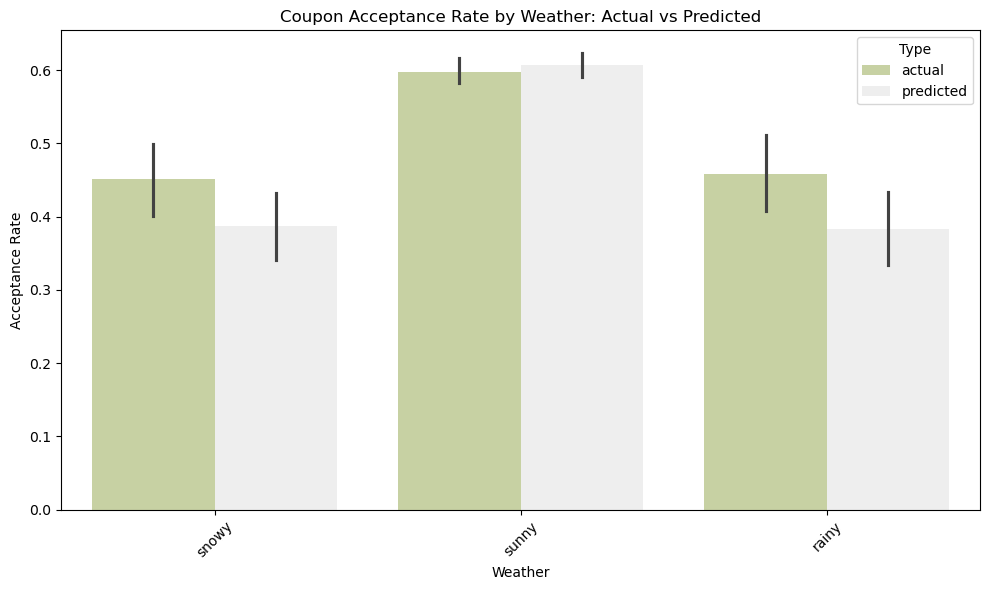

In [54]:
acceptance_by_weather = final_df.melt(id_vars='weather', value_vars=['actual', 'predicted'], 
                          var_name='Type', value_name='Acceptance Rate')

plt.figure(figsize=(10,6))
sns.barplot(data=acceptance_by_weather, x='weather', y='Acceptance Rate', hue='Type',palette=['#CBD99B', '#EEEEEE'])
plt.title('Coupon Acceptance Rate by Weather: Actual vs Predicted')
plt.xlabel('Weather')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sunny weather has the highest **actual** and **predicted acceptance rates**, while **rainy** and **snowy** conditions see much lower rates.  

The model closely mimics the real-world trend, underlining **weather's pivotal influence** on campaign success.  

**Duber** should leverage weather data, **targeting campaigns for clear days** to maximize effectiveness, just as the model recommends.

Coupon Acceptance Rate by Time of day: Actual vs Predicted

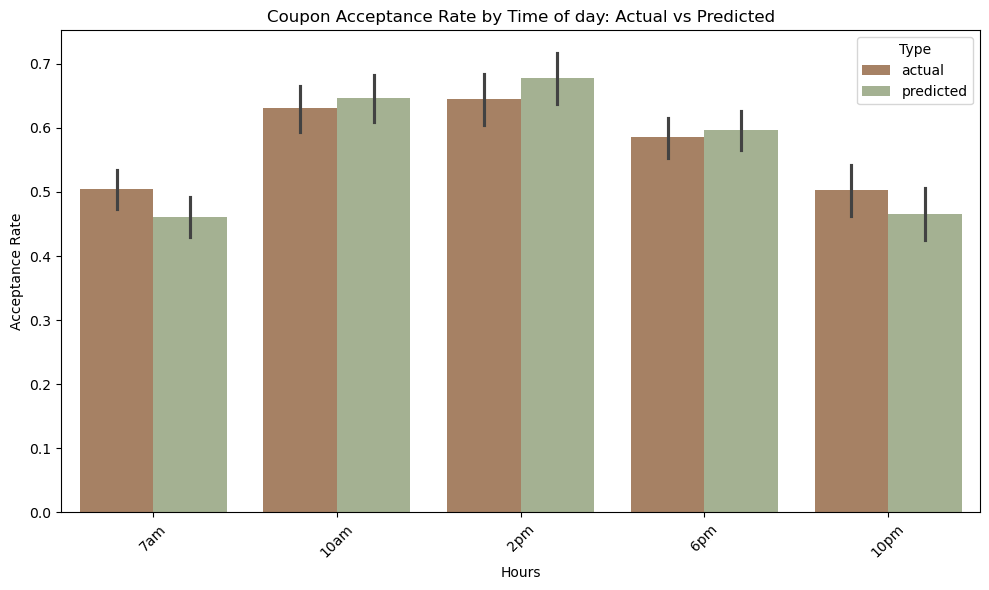

In [55]:
acceptance_by_time = final_df.melt(id_vars='time', value_vars=['actual', 'predicted'], 
                          var_name='Type', value_name='Acceptance Rate')

plt.figure(figsize=(10,6))
sns.barplot(data=acceptance_by_time, x='time', y='Acceptance Rate', hue='Type',order=time_order,palette=['#B17F59', '#A5B68D'])
plt.title('Coupon Acceptance Rate by Time of day: Actual vs Predicted')
plt.xlabel('Hours')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Mid-day (10AM–2PM)** and **evening (around 6PM)** time slots show the highest coupon acceptance, both in reality and in predictions.  

Lower rates are observed at **7AM** and **10PM**.  

The model specifically identifies the same peak periods, **validating its use for time-based coupon targeting**.  

**Duber**'s marketing can focus on **distributing coupons during mid-day and evening** for the best ROI.

Coupon Acceptance Rate by Income: Actual vs Predicted

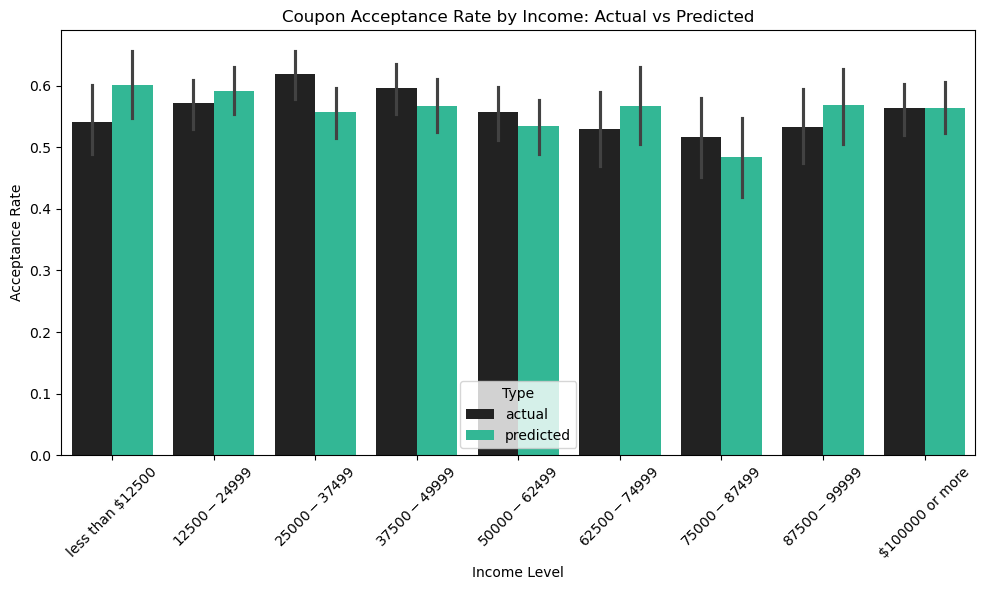

In [56]:
acceptance_by_income = final_df.melt(id_vars='income', value_vars=['actual', 'predicted'], 
                          var_name='Type', value_name='Acceptance Rate')

plt.figure(figsize=(10,6))
sns.barplot(data=acceptance_by_income, x='income', y='Acceptance Rate', hue='Type',order=income_order,palette=['#222222', '#1DCD9F'])
plt.title('Coupon Acceptance Rate by Income: Actual vs Predicted')
plt.xlabel('Income Level')
plt.ylabel('Acceptance Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Actual and predicted rates are highest for drivers in the **\$50,000– \$62,499** income range, while acceptance dips for both lower and higher income brackets — especially for those earning **$75,000–$87,499**.  

The alignment between model and reality indicates **strong predictive performance**.  

For **Duber**, this means campaigns can be more tightly **segmented by income**, targeting those most likely to respond and **reducing wasted spend**.

**Analysis**

Prior to adopting the machine learning model, Duber relied on broad, untargeted coupon distribution. EDA revealed several key behavioral patterns: drivers are notably more likely to accept coupons under sunny weather, for certain coupon types (“Carry out & Take away” and low-value restaurant offers), and when the destination is nearby. Income level and the time of day play a role too: middle-income individuals and those driving during mid-day are more receptive. The acceptance rate for distributed coupons hovered around 43%, indicating a substantial opportunity for improvement.

The post-model environment marks a transformative leap forward. With an optimized random forest model leveraged for prediction, Duber saw a meaningful increase in the ability to correctly identify likely coupon acceptors. Test set F1 score reached 0.755, with recall and precision similarly surpassing previous baselines. Crucially, the model pinpointed “Travel Distance to Coupon,” “Coupon Type,” “Weather,” “Time of Day,” and “Income” as the most influential variables in deciding acceptance. This means Duber can now segment, time, and tailor coupon pushes based not just on general trends, but on rigorous, data-backed individual predictions.

1. Why Duber Uses Recall and F1 Score:

· Recall measures the proportion of true coupon acceptors the model correctly identifies (Test Recall » 0.75 for RF Optimized). High recall is crucial because each missed acceptor (false negative) means Duber likely forfeits ~$20 in potential revenue. Maximizing recall directly increases sales, which fits Duber's business goal to capture as many real acceptors as possible.

· Precision measures how many predicted acceptors actually use the coupon. It's useful for controlling wasted spend but less costly to Duber than missing real conversions.

· F1 Score is the harmonic mean of recall and precision. Duber chose F1 Score to balance identifying as many real acceptors as possible (high recall) with not overwhelming the marketing budget on uninterested users (precision). F1 also handles the moderately imbalanced dataset (43% acceptance) more robustly than accuracy alone, which could be misleading.

2. Cost Analysis:

a. Business Impact of Each Error Type

· FP (False Positives): Cost of wasted coupon: $10 per case

· FN (False Negatives): Cost of lost revenue: $20 per missed conversion (as per business context).

· Total Cost Estimation on Test Set (Per 3806 Coupons):

o FP Cost: 514×$10 = $5140
o FN Cost: 539×$20=$10,780
o Total Cost: $5140 + $10780 = $15920


b. No Model vs. Model

**No Model**
- Total Cost: 1643×10=$16,430  
- Total Error Cost: No missed acceptances but many wasted coupons  
- ROI / Effectiveness: Low ROI, inefficient targeting with high overall spend 

**Model (RF Optimized)**
- Total Cost: $15920 
- Total Error Cost: Higher ROI, efficient targeting  
- ROI / Effectiveness: More accurate, cost-effective targeting  

3. Business Recommendations for Distribution Optimization:

a. Geo-targeted Offers Based on Distance and Situation: Duber should prioritize sending coupons when the pickup or destination is within 15 minutes of the coupon-offering business. Geo-fencing technology and route-tied triggers can help ensure offers aren’t sent to drivers unlikely to detour.

b. Timing and Weather Sensitivity: Coupons should be scheduled for distribution during periods with higher acceptance (mid-day, afternoon), and especially when forecasted weather is sunny. Rainy or snowy days should trigger reduced coupon marketing or focus on different offer types (e.g., coffeehouse rather than sit-down restaurants).

c. Segment and Personalize by Driver Demographics: Focus on moderate-income drivers ($50,000–$62,499) who statistically exhibit higher acceptance rates. Use model insights to weight probabilities per passenger type (e.g., offers to drivers alone) and time of day.

d. Optimize Coupon Types: “Carry Out & Take Away” and low-value restaurant coupons should form the core of Duber’s incentive structure, as these are most likely to be redeemed. Bar offers, frequently less accepted, should be targeted only when predicted uptake is high, or reconsidered for alternate marketing channels.

e. Automated, Model-Based Distribution: Integrate probabilistic thresholds into the marketing engine, only pushing coupons to drivers when their predicted acceptance score exceeds an optimal cut-off (such as >0.7). This will minimize false positives (wasted offers) and false negatives (missed conversions).

f. Continuous Learning and Feedback Loop: Duber should retrain and update models frequently as new behavioral data is collected. Real-world campaign performance should be closely

monitored. If certain segments or time slots underperform against predictions, model features and thresholds must be adjusted.

g. Monitor and Report ROI Metrics: As machine learning enhances targeting efficiency, Duber can track reductions in voucher wastage, improved campaign ROI, and increased net sales attributable to optimized coupon use. Visualization tools and regular business analysis are essential to sustaining these gains.

4. Challenges and Next Steps

a. Challenges:

· Survey data may not fully reflect live behavior; Duber must validate with real transactions.

· Drivers’ preferences and city conditions may change over time—models can drift.

· Raising recall too high may reduce precision, resulting in the waste of more coupons. Constant monitoring is needed!

· Integrating real-time predictions into Duber’s app and marketing workflow.

b. Next Steps:

· Deploy the model pilot and run live A/B tests against untargeted campaigns, measuring the real ROI of coupons.

· Refine thresholds and retrain with actual performance data.

· Expand feature tracking (e.g., live location, current weather, route info).

· Set up dashboards to continuously monitor recall, precision, and ROI.

· Apply privacy and ethical review for targeted marketing.

5.Conclusion

By moving from a “one-size-fits-all” coupon strategy to a refined, data-driven, and adaptive targeting system, Duber will be better positioned to reach its most promising customers, lift conversion rates, and maximize the return on its digital marketing spend. The integration of business context, statistical analysis, and cutting-edge predictive modeling not only optimizes incentive distribution but also fosters innovation and enables flexible adaptation in future marketing strategies.